In [2]:
import time 
import numpy as np

In [11]:
a=np.random.rand(1000000)
b=np.random.rand(1000000)

tic=time.time()
c=np.dot(a,b)
toc=time.time()

print('Vectorized version: '+str(1000*(toc-tic))+' ms')
print(c)

c=0
tic=time.time()
for i in range(1000000):
    c+=a[i]*b[i]
toc=time.time()

print('Vectorized version: '+str(1000*(toc-tic))+' ms')
print(c)

Vectorized version: 1.9943714141845703 ms
250218.76182233327
Vectorized version: 438.7040138244629 ms
250218.76182232998


## Broadcasting in python

In [14]:
import numpy as np

A=np.array([[56.0,0.0,4.4,68.0],
           [1.2,104.0,52.0,8.0],
           [1.8,135.0,99.0,0.9]])
print(A)

[[ 56.    0.    4.4  68. ]
 [  1.2 104.   52.    8. ]
 [  1.8 135.   99.    0.9]]


In [19]:
cal=A.sum(axis=0) #sum vertically
cal

array([ 59. , 239. , 155.4,  76.9])

In [22]:
percentage=100*A/cal #broadcasting
percentage

array([[94.91525424,  0.        ,  2.83140283, 88.42652796],
       [ 2.03389831, 43.51464435, 33.46203346, 10.40312094],
       [ 3.05084746, 56.48535565, 63.70656371,  1.17035111]])

In [36]:
a=np.random.randn(5)
a.shape

(5,)

# Excercise - 1

## Build a logistic regression model in python from scratch. Interpret logistic regression model as a neural network.

### Problem Statement: You are given a dataset ("data.h5") containing: - a training set of m_train images labeled as cat (y=1) or non-cat (y=0) - a test set of m_test images labeled as cat or non-cat - each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB). Thus, each image is square (height = num_px) and (width = num_px).

### You will build a simple image-recognition algorithm that can correctly classify pictures as cat or non-cat.

In [49]:
# !pip install h5py

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline

In [53]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [54]:
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

y = 0, it's a non-cat picture.


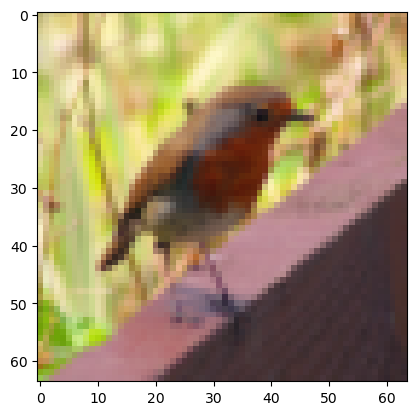

In [65]:
# example of picture
index=10
plt.imshow(train_set_x_orig[index])
print("y = "+str(train_set_y[0,index])+", it's a "+classes[np.squeeze(train_set_y[:,index])].decode("utf-8")+" picture.")

1. Exercise: Find the values for: - m_train (number of training examples) - m_test (number of test examples) - num_px (= height = width of a training image) Remember that train_set_x_orig is a numpy-array of shape (m_train, num_px, num_px, 3). For instance, you can access m_train by writing train_set_x_orig.shape[0].

In [73]:
m_train=len(train_set_x_orig)
m_test=len(test_set_x_orig)
num_px=train_set_x_orig.shape[1]

print(m_train)
print(m_test)
print(num_px)

209
50
64


2. Exercise: Reshape the training and test data sets so that images of size (num_px, num_px, 3) are flattened into single vectors of shape (num_px * num_px * 3, 1).

In [79]:
train_set_x_flatten=train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T
print("Shape of train_set_x_flatten "+str(train_set_x_flatten.shape))
test_set_x_flatten=test_set_x_orig.reshape(test_set_x_orig.shape[0],-1).T
print("Shape of test_set_x_flatten "+str(test_set_x_flatten.shape))

Shape of train_set_x_flatten (12288, 209)
Shape of test_set_x_flatten (12288, 50)


In [83]:
# Let's standardize our dataset
train_set_x=train_set_x_flatten/255
test_set_x=test_set_x_flatten/255

3. Excercise: Using your code from "Python Basics", implement sigmoid().


In [84]:
def sigmoid(z):
    s=1/(1+np.exp(-z))
    return s

In [85]:
print("sigmoid([0, 2]) = " + str(sigmoid(np.array([0,2]))))

sigmoid([0, 2]) = [0.5        0.88079708]


4. Exercise: Implement parameter initialization in the cell below. You have to initialize w as a vector of zeros. If you don't know what numpy function to use, look up np.zeros() in the Numpy library's documentation.

In [86]:
def initialize_with_zeros(dim):
    w=np.zeros((dim,1))
    b=0
    
    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w,b

In [89]:
dim=2
w,b=initialize_with_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]]
b = 0


5. Exercise: Implement a function propagate() that computes the cost function and its gradient.

In [95]:
# Arguments:
# w -- weights, a numpy array of size (num_px * num_px * 3, 1)
# b -- bias, a scalar
# X -- data of size (num_px * num_px * 3, number of examples) -> (nx,m)
# Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

# Return:
# cost -- negative log-likelihood cost for logistic regression
# dw -- gradient of the loss with respect to w, thus same shape as w
# db -- gradient of the loss with respect to b, thus same shape as b

# Tips:
# - Write your code step by step for the propagation. np.log(), np.dot()

def propagate(w,b,X,Y):
    m=X.shape[1]
    
    # forward propagation
    A=sigmoid(np.dot(w.T,X)+b)  # Compute activation
    cost=np.sum(((- np.log(A))*Y + (- np.log(1-A))*(1-Y)))/m    # compute cost
    
    # backward propagation
    dw=(np.dot(X,(A-Y).T))/m
    db=(np.sum(A-Y))/m
    
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [96]:
w, b, X, Y = np.array([[1.],[2.]]), 2., np.array([[1.,2.,-1.],[3.,4.,-3.2]]), np.array([[1,0,1]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[0.99845601]
 [2.39507239]]
db = 0.001455578136784208
cost = 5.801545319394553


6. Exercise: Write down the optimization function. 

In [97]:
"""
This function optimizes w and b by running a gradient descent algorithm

Arguments:
w -- weights, a numpy array of size (num_px * num_px * 3, 1)
b -- bias, a scalar
X -- data of shape (num_px * num_px * 3, number of examples)
Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
num_iterations -- number of iterations of the optimization loop
learning_rate -- learning rate of the gradient descent update rule
print_cost -- True to print the loss every 100 steps

Returns:
params -- dictionary containing the weights w and bias b
grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.

Tips:
You basically need to write down two steps and iterate through them:
    1) Calculate the cost and the gradient for the current parameters. Use propagate().
    2) Update the parameters using gradient descent rule for w and b.
"""

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    costs=[]
    for i in range(num_iterations):
        grads,cost=propagate(w,b,X,Y)
        
        # Retrieve derivatives from grads
        dw=grads['dw']
        db=grads['db']
        
        # update rule
        w=w-(learning_rate*dw)
        b=b-(learning_rate*db)
        
        # Record the costs
        if i%100==0:
            costs.append(cost)
            
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [98]:
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[0.19033591]
 [0.12259159]]
b = 1.9253598300845747
dw = [[0.67752042]
 [1.41625495]]
db = 0.21919450454067654


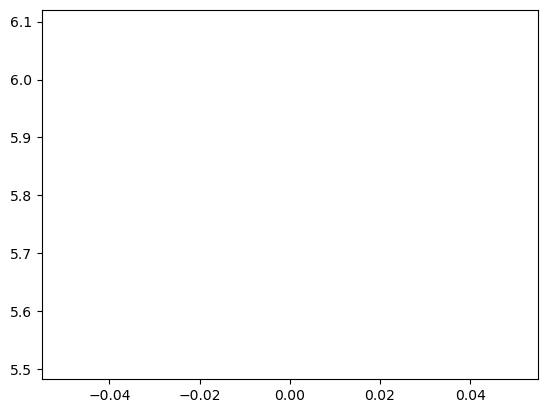

In [106]:
import matplotlib.pyplot as plt
plt.plot(costs)

7. Exercise: The previous function will output the learned w and b. We are able to use w and b to predict the labels for a dataset X. Implement the predict() function. There are two steps to computing predictions:

In [169]:
'''
Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)

Arguments:
w -- weights, a numpy array of size (num_px * num_px * 3, 1)
b -- bias, a scalar
X -- data of size (num_px * num_px * 3, number of examples)

Returns:
Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
'''

def predict(w,b,X):
    m=X.shape[1]
    Y_prediction=np.zeros((1,m))
    w=w.reshape(X.shape[0],1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    
    A=sigmoid(np.dot(w.T,X)+b)  # Dimentions = (1, m)
    Y_prediction=(A>=0.5)*1.0
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [170]:
w = np.array([[0.1124579],[0.23106775]])
b = -0.3
X = np.array([[1.,-1.1,-3.2],[1.2,2.,0.1]])
print ("predictions = " + str(predict(w, b, X)))

predictions = [[1. 1. 0.]]


### Merge all functions into a model

In [171]:
"""
Builds the logistic regression model by calling the function you've implemented previously

Arguments:
X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
print_cost -- Set to true to print the cost every 100 iterations

Returns:
d -- dictionary containing information about the model.
"""

def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    # initialize parameters with zeros
    w, b = initialize_with_zeros(X_train.shape[0])
    
    # Gradient descent
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples
    Y_prediction_test = predict(w, b, X_test)
    print(Y_prediction_test)
    Y_prediction_train = predict(w, b, X_train)
    
    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))
    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [172]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = False)

[[1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1.
  1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1.
  1. 0.]]
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


y = 1, you predicted that it is a "cat" picture.


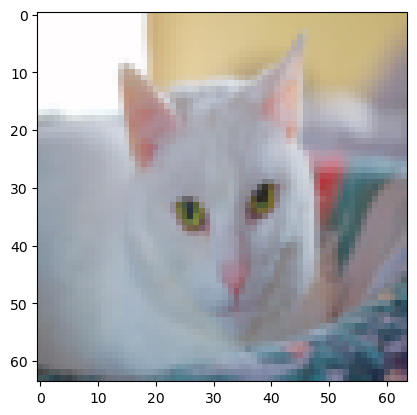

In [204]:
# Example of a picture that was wrongly classified.
index = 2
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[0,index]) + ", you predicted that it is a \"" + classes[int(np.squeeze(d["Y_prediction_test"][0,index]))].decode("utf-8") +  "\" picture.")

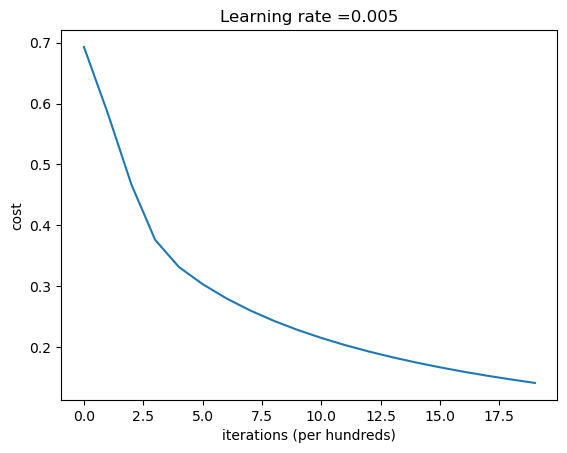

In [205]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

### Choice of learning rate

learning rate is: 0.1


C:\Users\mavis\AppData\Local\Temp\ipykernel_9080\604064679.py:20: RuntimeWarning: divide by zero encountered in log
  cost=np.sum(((- np.log(A))*Y + (- np.log(1-A))*(1-Y)))/m    # compute cost
C:\Users\mavis\AppData\Local\Temp\ipykernel_9080\604064679.py:20: RuntimeWarning: invalid value encountered in multiply
  cost=np.sum(((- np.log(A))*Y + (- np.log(1-A))*(1-Y)))/m    # compute cost


[[1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1.
  1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1.
  1. 0.]]
train accuracy: 100.0 %
test accuracy: 70.0 %

-------------------------------------------------------

learning rate is: 0.01
[[1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1.
  1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1.
  1. 0.]]
train accuracy: 99.52153110047847 %
test accuracy: 68.0 %

-------------------------------------------------------

learning rate is: 0.001
[[1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0.
  1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1.
  0. 0.]]
train accuracy: 88.99521531100478 %
test accuracy: 64.0 %

-------------------------------------------------------

learning rate is: 0.0001
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

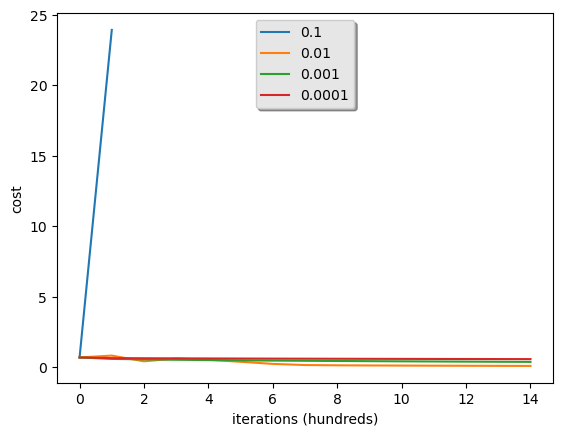

In [176]:
learning_rates = [0.1, 0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()